In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from scipy.optimize import milp, LinearConstraint, Bounds
import pulp

In [3]:
def get_fpl_data():
    base_url = "https://fantasy.premierleague.com/api/bootstrap-static/"
    response = requests.get(base_url)
    data = response.json()
    return data

In [4]:
def get_fixtures_df():
    url = "https://fantasy.premierleague.com/api/fixtures/"
    return pd.DataFrame(requests.get(url).json())

fixtures_df = get_fixtures_df()


In [5]:
fpl_data = get_fpl_data()

In [6]:
fpl_data.keys()

dict_keys(['chips', 'events', 'game_settings', 'game_config', 'phases', 'teams', 'total_players', 'element_stats', 'element_types', 'elements'])

In [7]:
teams_data = fpl_data['teams']
players_data = fpl_data['elements']
gameweek_data = fpl_data['events']
chips = fpl_data['chips']
game_config = fpl_data['game_config']

In [8]:
def get_next_gw(gw):
    ev = pd.DataFrame(gw)[["id", "is_next", "is_current", "finished"]].copy()
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
    if (ev["finished"] == False).any():
        return int(ev.loc[ev["finished"] == False, "id"].min())
    return int(ev["id"].max())

def team_event_fdr(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum"),
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

In [9]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    return pd.concat([home, away], ignore_index=True)

fx_long = fixtures_long_fdr(fixtures_df)


In [10]:
mapping = {1: "gk", 2: "def", 3: "mid", 4: "att"}  

In [11]:
print(players_data[1]['chance_of_playing_this_round'])
players_data[0].keys()

None


dict_keys(['can_transact', 'can_select', 'chance_of_playing_next_round', 'chance_of_playing_this_round', 'code', 'cost_change_event', 'cost_change_event_fall', 'cost_change_start', 'cost_change_start_fall', 'dreamteam_count', 'element_type', 'ep_next', 'ep_this', 'event_points', 'first_name', 'form', 'id', 'in_dreamteam', 'news', 'news_added', 'now_cost', 'photo', 'points_per_game', 'removed', 'second_name', 'selected_by_percent', 'special', 'squad_number', 'status', 'team', 'team_code', 'total_points', 'transfers_in', 'transfers_in_event', 'transfers_out', 'transfers_out_event', 'value_form', 'value_season', 'web_name', 'region', 'team_join_date', 'birth_date', 'has_temporary_code', 'opta_code', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defen

In [12]:
players_data_df = pd.DataFrame(players_data)

In [13]:
players_data_df = players_data_df[['now_cost','total_points', 'element_type', 'goals_scored', 'bps','assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'influence', 'creativity', 'threat', 'ict_index', 'clearances_blocks_interceptions', 'recoveries', 'tackles', 'defensive_contribution', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'form', 'starts', 'minutes','web_name', 'team', 'chance_of_playing_this_round']]
players_data_df["element_type"] = players_data_df["element_type"].map(mapping)


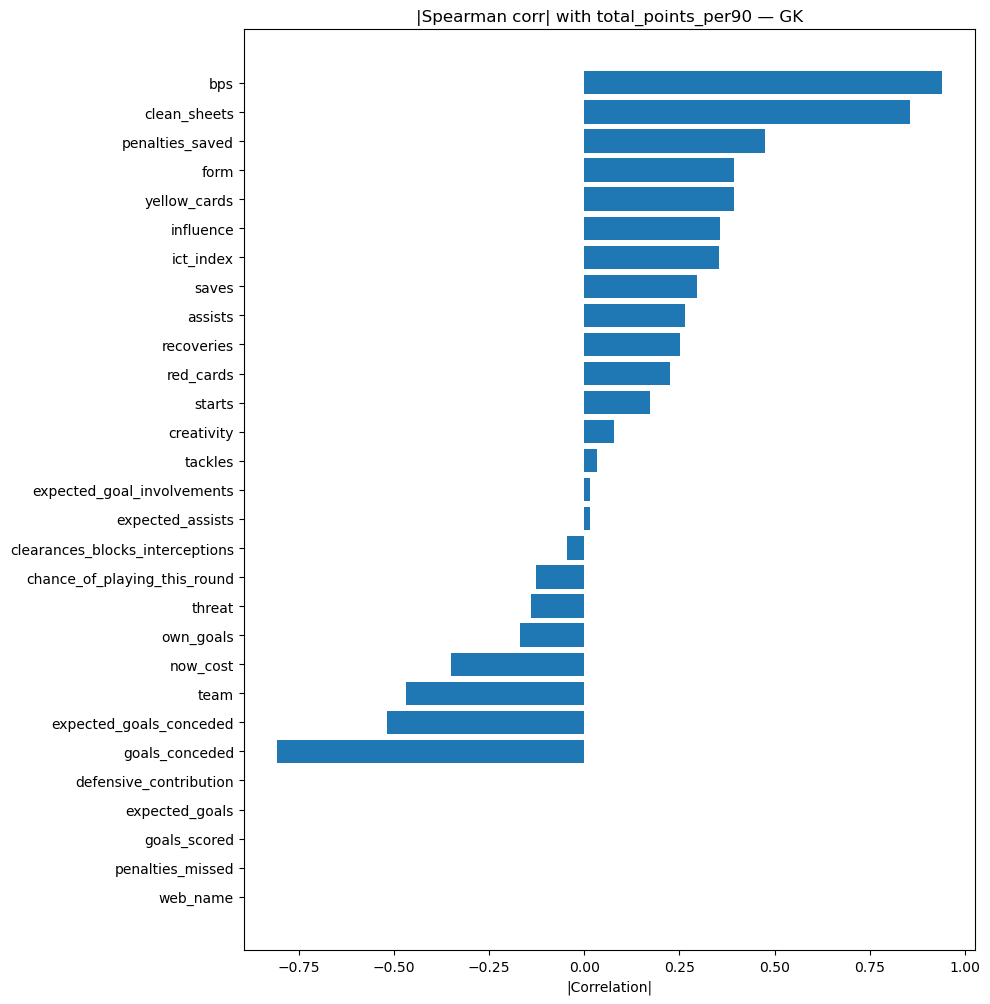

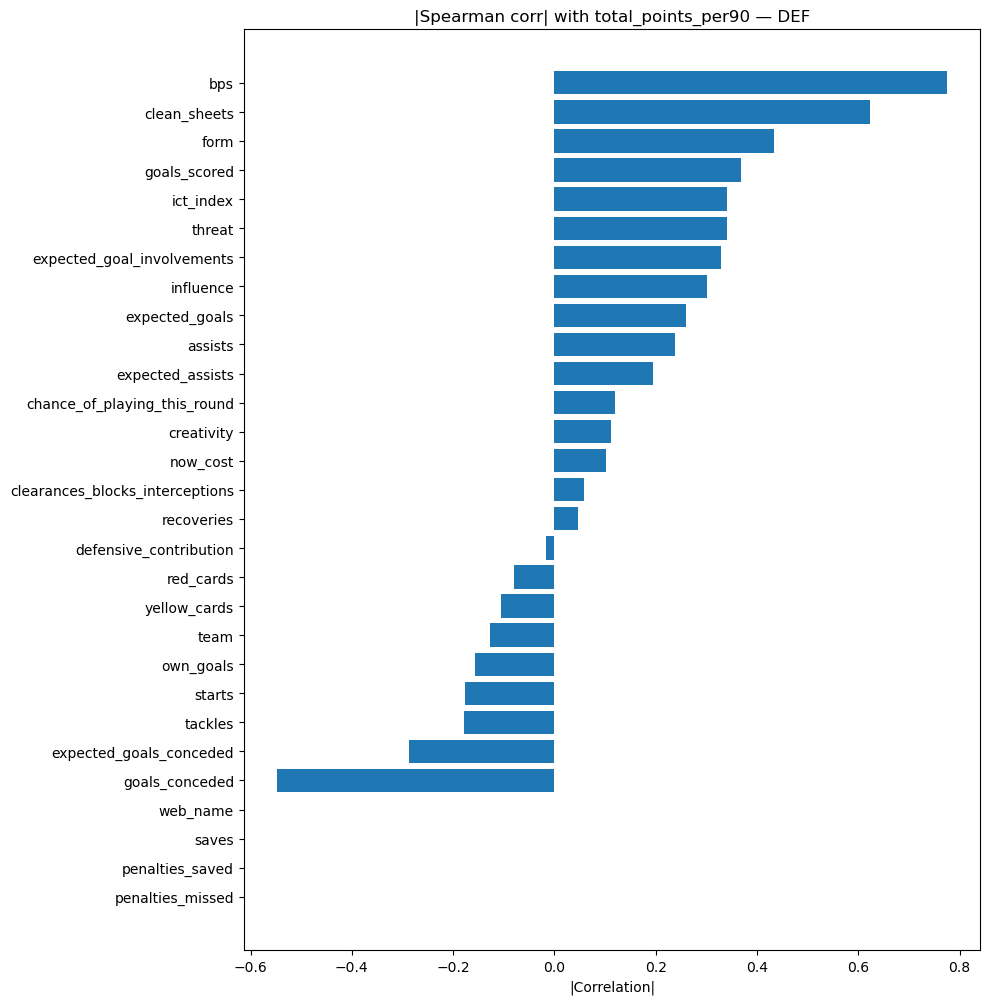

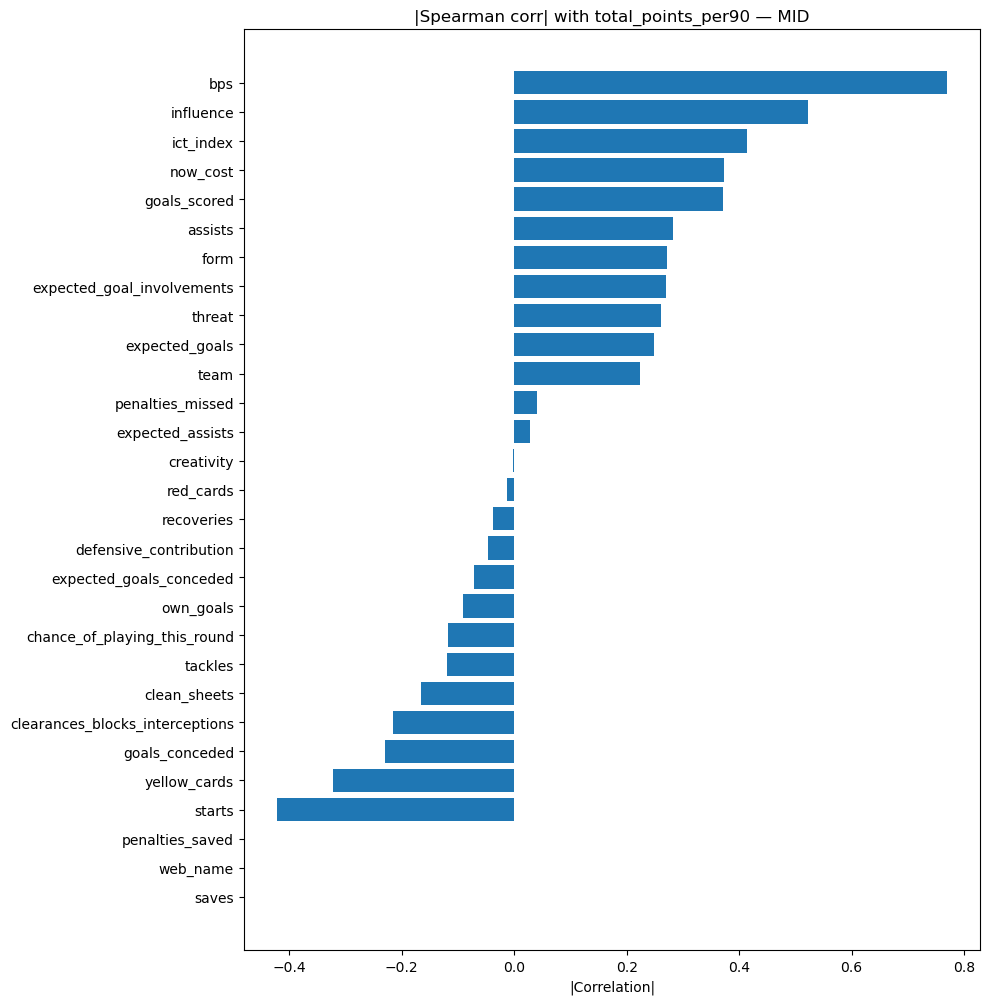

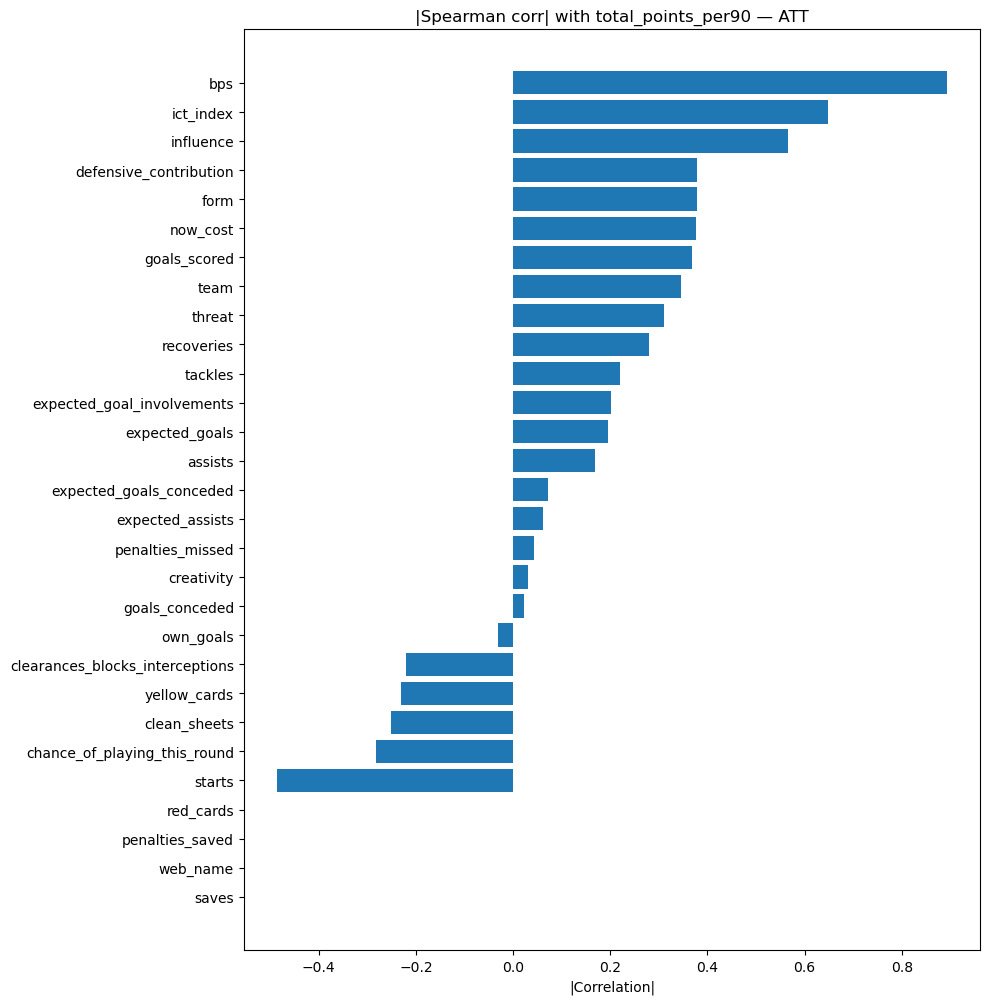

In [14]:
def corr_plots_by_position_per90_abs(
    df: pd.DataFrame,
    group_col: str = "element_type",
    target: str = "total_points",
    minutes_col: str = "minutes",
    positions=("gk", "def", "mid", "att"),
    method: str = "spearman",
):
    d = df.copy()

    for c in d.columns:
        if c != group_col:
            d[c] = pd.to_numeric(d[c], errors="coerce")

    num_cols = d.select_dtypes(include="number").columns
    if target not in num_cols or minutes_col not in num_cols:
        raise ValueError(f"'{target}' and '{minutes_col}' must be numeric columns in df.")

    denom = d[minutes_col].replace(0, np.nan) / 90.0
    per90 = d[num_cols].div(denom, axis=0)
    per90[minutes_col] = d[minutes_col]
    

    features = [c for c in num_cols if c not in (target, minutes_col)]
    corr_df = pd.DataFrame(index=list(positions), columns=features, dtype=float)

    for pos in positions:
        sub = per90.loc[d[group_col] == pos, [target] + features]
        if len(sub) < 2:
            continue

        s = sub.corr(method=method)[target].reindex(features)
    
        s_sorted = s.reindex(s.fillna(-1).sort_values(ascending=False).index).fillna(0)

        plt.figure(figsize=(10, max(4, 0.35 * len(s_sorted))))
        y = np.arange(len(s_sorted))
        plt.barh(y, s_sorted.values)
        plt.yticks(y, s_sorted.index)
        plt.gca().invert_yaxis()
        plt.title(f"|{method.title()} corr| with {target}_per90 — {pos.upper()}")
        plt.xlabel("|Correlation|")
        plt.tight_layout()
        plt.show()

        corr_df.loc[pos] = s

    return corr_df

corr_df = corr_plots_by_position_per90_abs(
    players_data_df,
    group_col="element_type",
    target="total_points",
    minutes_col="minutes",
    method="spearman",
)


In [42]:
def get_bootstrap():
    return requests.get("https://fantasy.premierleague.com/api/bootstrap-static/").json()

def get_fixtures_df():
    return pd.DataFrame(requests.get("https://fantasy.premierleague.com/api/fixtures/").json())

fpl_data = get_bootstrap()
fixtures_df = get_fixtures_df()

players_data = fpl_data["elements"]
events_data = fpl_data["events"]


In [43]:
players_meta_df = pd.DataFrame(players_data)[
    ["id","web_name","element_type","team","now_cost","chance_of_playing_this_round"]
].copy()

players_meta_df["id"] = pd.to_numeric(players_meta_df["id"], errors="coerce").astype(int)
players_meta_df["element_type"] = pd.to_numeric(players_meta_df["element_type"], errors="coerce").astype(int)
players_meta_df["team"] = pd.to_numeric(players_meta_df["team"], errors="coerce").astype(int)
players_meta_df["now_cost"] = pd.to_numeric(players_meta_df["now_cost"], errors="coerce")
players_meta_df["chance_of_playing_this_round"] = pd.to_numeric(players_meta_df["chance_of_playing_this_round"], errors="coerce").fillna(100)


In [44]:
def fixtures_long_fdr(fixtures_df):
    f = fixtures_df.loc[fixtures_df["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = pd.DataFrame({
        "event": f["event"],
        "team": f["team_h"],
        "opponent_team": f["team_a"],
        "was_home": 1,
        "fdr": f["team_h_difficulty"]
    })
    away = pd.DataFrame({
        "event": f["event"],
        "team": f["team_a"],
        "opponent_team": f["team_h"],
        "was_home": 0,
        "fdr": f["team_a_difficulty"]
    })
    return pd.concat([home, away], ignore_index=True)

fx_long = fixtures_long_fdr(fixtures_df)


In [45]:
def get_element_summary(player_id):
    url = f"https://fantasy.premierleague.com/api/element-summary/{player_id}/"
    return requests.get(url).json()

def build_player_gw_history(players_meta_df, fx_long):
    rows = []
    for pid in players_meta_df["id"].tolist():
        j = get_element_summary(int(pid))
        h = pd.DataFrame(j.get("history", []))
        if len(h) == 0:
            continue
        h["id"] = int(pid)
        rows.append(h)

    hist = pd.concat(rows, ignore_index=True)

    keep = [
        "id","round","opponent_team","was_home","total_points","minutes",
        "goals_scored","assists","clean_sheets","goals_conceded","saves",
        "penalties_saved","penalties_missed","yellow_cards","red_cards",
        "influence","creativity","threat","ict_index",
        "expected_goals","expected_assists","expected_goals_conceded",
        "value"
    ]
    keep = [c for c in keep if c in hist.columns]
    hist = hist[keep].copy()

    hist["id"] = pd.to_numeric(hist["id"], errors="coerce").astype(int)

    hist = hist.merge(
        players_meta_df[["id","web_name","element_type","team"]],
        on="id",
        how="left"
    )

    hist["round"] = pd.to_numeric(hist["round"], errors="coerce").astype(int)
    hist["team"] = pd.to_numeric(hist["team"], errors="coerce").astype(int)
    hist["opponent_team"] = pd.to_numeric(hist["opponent_team"], errors="coerce").astype(int)
    hist["was_home"] = pd.to_numeric(hist["was_home"], errors="coerce").astype(int)

    hist = hist.merge(
        fx_long,
        left_on=["round","team","opponent_team","was_home"],
        right_on=["event","team","opponent_team","was_home"],
        how="left"
    ).drop(columns=["event"])

    hist = hist.rename(columns={"total_points":"gw_points", "value":"now_cost"})
    hist["fdr"] = pd.to_numeric(hist["fdr"], errors="coerce").fillna(3.0)
    hist["now_cost"] = pd.to_numeric(hist["now_cost"], errors="coerce")

    return hist

player_gw_df = build_player_gw_history(players_meta_df, fx_long)


In [46]:
def add_rolling_features(df, group_col="id", time_col="round", windows=(5,), shift=1, cols=None):
    d = df.copy()
    d[time_col] = pd.to_numeric(d[time_col], errors="coerce")
    d = d.sort_values([group_col, time_col])

    if cols is None:
        cols = [
            "minutes","goals_scored","assists","clean_sheets","goals_conceded","saves",
            "expected_goals","expected_assists","expected_goals_conceded",
            "influence","creativity","threat","ict_index"
        ]
    cols = [c for c in cols if c in d.columns]

    for c in cols:
        d[c] = pd.to_numeric(d[c], errors="coerce")

    for w in windows:
        rolled = d.groupby(group_col, sort=False)[cols].rolling(w, min_periods=1).mean()
        if shift:
            rolled = rolled.shift(shift)
        rolled = rolled.reset_index(level=0, drop=True)
        rolled.columns = [f"{c}_r{w}" for c in cols]
        d = pd.concat([d, rolled], axis=1)

    return d

train_df = add_rolling_features(player_gw_df, windows=(5,), shift=1)


In [47]:
def get_current_gw(events):
    ev = pd.DataFrame(events)
    if (ev["is_current"] == True).any():
        return int(ev.loc[ev["is_current"] == True, "id"].iloc[0])
    if (ev["is_next"] == True).any():
        return int(ev.loc[ev["is_next"] == True, "id"].iloc[0]) - 1
    return int(ev["id"].max())

target_gw = get_current_gw(events_data)


In [ ]:
feature_map_gw = {
    1: ["now_cost","fdr","clean_sheets_r5","goals_conceded_r5","saves_r5","expected_goals_conceded_r5","minutes_r5"],
    2: ["now_cost","fdr","clean_sheets_r5","goals_conceded_r5","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","expected_goals_conceded_r5","minutes_r5"],
    3: ["now_cost","fdr","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","creativity_r5","threat_r5","influence_r5","minutes_r5"],
    4: ["now_cost","fdr","assists_r5","goals_scored_r5","expected_goals_r5","expected_assists_r5","threat_r5","influence_r5","minutes_r5"]
}

def fit_predict_by_position(df, feature_map, target="gw_points", pos_col="element_type", pred_col="xgb_pred", params=None):
    d = df.copy()
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[target] = pd.to_numeric(d[target], errors="coerce")
    d[pred_col] = np.nan

    base_params = dict(
        n_estimators=800,
        learning_rate=0.03,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42
    )
    if params:
        base_params.update(params)

    models = {}
    
    for pos, feats in feature_map.items():
        sub = d.loc[d[pos_col].eq(pos), feats + [target]].copy()
        if len(sub) < 2:
            continue

        for c in feats:
            sub[c] = pd.to_numeric(sub[c], errors="coerce")

        sub = sub.dropna(subset=[target])
        if len(sub) < 2:
            continue

        X = sub[feats].fillna(0)
        y = sub[target].to_numpy()

        if len(sub) < 20:
            model = XGBRegressor(**base_params)
            model.fit(X, y, verbose=False)
        else:
            X_tr, X_va, y_tr, y_va = train_test_split(X, y, test_size=0.2, random_state=42)
            model = XGBRegressor(**base_params)
            model.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], verbose=False)

        models[pos] = model
        d.loc[sub.index, pred_col] = model.predict(X)

    return d, models


In [53]:
train_cut = train_df.loc[train_df["round"] < target_gw].copy()

train_cut_with_preds, models = fit_predict_by_position(
    train_cut,
    feature_map_gw,
    target="gw_points",
    pos_col="element_type",
    pred_col="xgb_pred"
)

train_cut_with_preds

,id,round,opponent_team,was_home,gw_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,goals_conceded_r5,saves_r5,expected_goals_r5,expected_assists_r5,expected_goals_conceded_r5,influence_r5,creativity_r5,threat_r5,ict_index_r5,xgb_pred
0,1,1,14,0,10,90,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.494012
1,1,2,11,1,6,90,0,0,1,0,...,0.000000,7.000000,0.0,0.000000,1.520000,49.200000,0.000000,0.0,4.900000,5.642466
2,1,3,12,0,2,90,0,0,0,1,...,0.000000,4.000000,0.0,0.000000,0.845000,31.300000,0.000000,0.0,3.100000,2.466735
3,1,4,16,1,6,90,0,0,1,0,...,0.333333,3.333333,0.0,0.006667,0.736667,27.533333,3.333333,0.0,3.066667,5.887127
4,1,5,13,1,2,90,0,0,0,1,...,0.250000,2.750000,0.0,0.005000,0.602500,23.850000,2.500000,0.0,2.625000,1.545090
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13386,766,17,5,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052288
13388,767,17,5,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.022062
1388,768,17,14,1,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.052288
9298,769,17,2,0,0,0,0,0,0,0,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.022062


In [54]:
def team_event_fdr(fixtures_df):
    f = fixtures_df.copy()
    f = f.loc[f["event"].notna(), ["event","team_h","team_a","team_h_difficulty","team_a_difficulty"]].copy()
    f["event"] = f["event"].astype(int)

    home = f.rename(columns={"team_h":"team","team_a":"opponent","team_h_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    home["is_home"] = 1
    away = f.rename(columns={"team_a":"team","team_h":"opponent","team_a_difficulty":"fdr"})[["team","event","opponent","fdr"]]
    away["is_home"] = 0

    long = pd.concat([home, away], ignore_index=True)

    out = long.groupby(["team","event"], as_index=False).agg(
        fdr=("fdr","mean"),
        games=("fdr","size"),
        home_games=("is_home","sum")
    )
    out["away_games"] = out["games"] - out["home_games"]
    return out

def build_team_future_fdr(team_event_df, start_gw, horizon=3):
    d1 = team_event_df.loc[team_event_df["event"].eq(start_gw), ["team","fdr","games"]].copy()
    d1 = d1.rename(columns={"fdr":"fdr_1","games":"games_1"})

    dh = team_event_df.loc[team_event_df["event"].between(start_gw, start_gw + horizon - 1), ["team","fdr","games"]].copy()
    agg = dh.groupby("team", as_index=False).agg(
        **{
            f"fdr_mean_{horizon}": ("fdr","mean"),
            f"games_{horizon}": ("games","sum"),
        }
    )

    out = agg.merge(d1, on="team", how="left")
    return out

def add_fixture_difficulty_features(players_df, fixtures_df, events_df, team_col="team", start_gw=None, horizon=3, fdr_fill=3.0):
    if start_gw is None:
        ev = pd.DataFrame(events_df)
        if (ev["is_next"] == True).any():
            start_gw = int(ev.loc[ev["is_next"] == True, "id"].iloc[0])
        elif (ev["is_current"] == True).any():
            start_gw = int(ev.loc[ev["is_current"] == True, "id"].iloc[0]) + 1
        else:
            start_gw = int(ev["id"].max())

    te = team_event_fdr(fixtures_df)
    tf = build_team_future_fdr(te, start_gw=start_gw, horizon=horizon)

    out = players_df.merge(tf, on="team", how="left")

    out["fdr_1"] = pd.to_numeric(out["fdr_1"], errors="coerce").fillna(fdr_fill)
    out["games_1"] = pd.to_numeric(out["games_1"], errors="coerce").fillna(0).astype(int)
    out[f"fdr_mean_{horizon}"] = pd.to_numeric(out[f"fdr_mean_{horizon}"], errors="coerce").fillna(fdr_fill)
    out[f"games_{horizon}"] = pd.to_numeric(out[f"games_{horizon}"], errors="coerce").fillna(0).astype(int)

    return out


In [55]:
state_df = player_gw_df.loc[player_gw_df["round"] < target_gw].copy()
state_df = add_rolling_features(state_df, windows=(5,), shift=0)

latest_state = state_df.sort_values(["id","round"]).groupby("id", as_index=False).tail(1).copy()

keep_cols = ["id","element_type","team","web_name"] + [c for c in latest_state.columns if c.endswith("_r5")]
pred_df = latest_state[keep_cols].copy()

pred_df = pred_df.merge(
    players_meta_df[["id","now_cost","chance_of_playing_this_round"]],
    on="id",
    how="left"
)

pred_df = pred_df.merge(
    add_fixture_difficulty_features(
        players_meta_df[["team"]].drop_duplicates().merge(players_meta_df[["team"]], on="team"),
        fixtures_df,
        pd.DataFrame(events_data),
        start_gw=target_gw,
        horizon=3
    )[["team","fdr_1","games_1","fdr_mean_3","games_3"]].drop_duplicates(),
    on="team",
    how="left"
)

pred_df["fdr_1"] = pd.to_numeric(pred_df["fdr_1"], errors="coerce").fillna(3.0)
pred_df["games_1"] = pd.to_numeric(pred_df["games_1"], errors="coerce").fillna(0).astype(int)
pred_df["chance_of_playing_this_round"] = pd.to_numeric(pred_df["chance_of_playing_this_round"], errors="coerce").fillna(100)


In [56]:
pred_df = pred_df.copy()
pred_df["fdr"] = pred_df["fdr_1"]

pred_df["xgb_pred"] = np.nan
for pos, feats in feature_map_gw.items():
    sub = pred_df.loc[pred_df["element_type"].eq(pos)]
    if len(sub):
        pred_df.loc[sub.index, "xgb_pred"] = models[pos].predict(sub[feats].fillna(0))

pred_df["gw_score"] = pred_df["xgb_pred"] * pred_df["games_1"]


In [58]:
solver = pulp.COIN_CMD(msg=False) 

In [ ]:
def pick_starting_xi(
    df,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    team_col="team",
    chance_col="chance_of_playing_this_round",
    budget=81.5,
    pos_limits={1: (1, 1), 2: (3, 5), 3: (3, 5), 4: (1, 3)},
    max_from_team=3,
):
    d = df.copy()

    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d[pos_col] = pd.to_numeric(d[pos_col], errors="coerce")
    d[chance_col] = pd.to_numeric(d.get(chance_col, 100), errors="coerce").fillna(100)

    d = d.dropna(subset=[points_col, cost_col, pos_col, team_col]).reset_index(drop=True)
    d = d.loc[d[chance_col].gt(0)].reset_index(drop=True)

    if len(d) < 11:
        raise ValueError("Not enough available players after filtering chance_of_playing_this_round > 0.")

    cost_is_tenths = d[cost_col].max() > 25
    costs = d[cost_col].to_numpy(dtype=float)
    B = budget * 10 if cost_is_tenths else float(budget)

    if cost_is_tenths:
        costs = np.round(costs).astype(int)
        B = int(round(B))

    points = d[points_col].to_numpy(dtype=float)
    n = len(d)

    c = -points
    integrality = np.ones(n, dtype=int)
    bounds = Bounds(0, 1)

    rows = []
    lb = []
    ub = []

    rows.append(np.ones(n))
    lb.append(11)
    ub.append(11)

    rows.append(costs.astype(float))
    lb.append(-np.inf)
    ub.append(B)

    pos_arr = d[pos_col].astype(int).to_numpy()
    for pos, (mn, mx) in pos_limits.items():
        mask = (pos_arr == int(pos)).astype(float)
        if mask.sum() == 0:
            raise ValueError(f"No players found for position {pos}.")
        rows.append(mask)
        lb.append(mn)
        ub.append(mx)

    team_arr = d[team_col].to_numpy()
    for t in pd.unique(team_arr):
        mask = (team_arr == t).astype(float)
        rows.append(mask)
        lb.append(-np.inf)
        ub.append(max_from_team)

    A = np.vstack(rows)
    constraints = LinearConstraint(A, lb, ub)

    res = milp(c=c, integrality=integrality, bounds=bounds, constraints=constraints)
    if res.status != 0:
        raise RuntimeError(res.message)

    chosen = res.x > 0.5
    xi = d.loc[chosen].copy()

    total_pred = float(xi[points_col].sum())
    total_cost = float(xi[cost_col].sum())
    total_cost_gbp = total_cost / 10 if cost_is_tenths else total_cost

    return xi, total_pred, total_cost_gbp



In [ ]:
def show_xi_neatly_plain(
    xi,
    points_col="gw_score",
    cost_col="now_cost",
    pos_col="element_type",
    name_col="web_name",
    team_col="team",
    gw_col="gw",
    opp_col="opponent_team",
    home_col="was_home",
    team_name_map=None,
):
    d = xi.copy()

    d[points_col] = pd.to_numeric(d[points_col], errors="coerce")
    d[cost_col] = pd.to_numeric(d[cost_col], errors="coerce")
    d["cost_gbp"] = np.where(d[cost_col] > 25, d[cost_col] / 10, d[cost_col])

    pos_map = {1: "GK", 2: "DEF", 3: "MID", 4: "FWD"}
    d["position"] = pd.to_numeric(d[pos_col], errors="coerce").map(pos_map)

    if team_name_map is not None:
        d["team_name"] = d[team_col].map(team_name_map)
        if opp_col in d.columns:
            d["opp_name"] = d[opp_col].map(team_name_map)
    else:
        d["team_name"] = d[team_col]
        if opp_col in d.columns:
            d["opp_name"] = d[opp_col]

    if opp_col in d.columns:
        ha = ""
        if home_col in d.columns:
            ha = np.where(pd.to_numeric(d[home_col], errors="coerce").fillna(0).astype(int).eq(1), " (H)", " (A)")
        d["fixture"] = d["opp_name"].astype(str) + ha
    else:
        d["fixture"] = ""

    cap_idx = d[points_col].idxmax()
    d["role"] = ""
    d.loc[cap_idx, "role"] = "(C)"

    d["pos_order"] = pd.to_numeric(d[pos_col], errors="coerce").map({1:0,2:1,3:2,4:3}).fillna(9).astype(int)

    cols = ["role", name_col, "position", "team_name"]
    if gw_col in d.columns:
        cols += [gw_col]
    cols += ["fixture", "cost_gbp", points_col]

    out = d.sort_values(["pos_order", points_col], ascending=[True, False])[cols].copy()
    out["cost_gbp"] = out["cost_gbp"].round(1)
    out[points_col] = out[points_col].round(2)
    return out

xi_view = show_xi_neatly_plain(xi, points_col="gw_score")
print(xi_view.to_string(index=False))


role      web_name position  team_name fixture  cost_gbp  gw_score
          Petrović       GK          4               4.5      4.89
         Mykolenko      DEF          9               4.9      6.93
             Keane      DEF          9               4.7      6.79
         Tarkowski      DEF          9               5.5      6.56
            Virgil      DEF         12               5.9      6.49
           Ballard      DEF         17               4.7      5.98
          Garnacho      MID          7               6.4      6.80
          E.Le Fée      MID         17               4.9      5.76
            Cherki      MID         13               6.6      5.56
 (C)       Haaland      FWD         13              15.1      9.31
     Calvert-Lewin      FWD         11               5.8      8.97
